### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.13.0+cu116


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = (img / 255) * 2 - 1 # pixel ranges from -1 to 1.
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


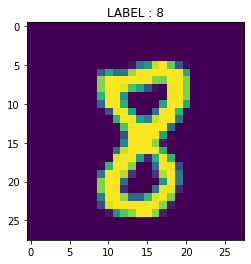

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the GAN (Generator + Discriminator)


In [ ]:
class Generator(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(Generator, self).__init__()
        
        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define generator : dim_z -> dim_input.
        self.fc_1 = nn.Linear(dim_z, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, dim_input)
        
        self.bn_1 = nn.BatchNorm1d(dim_hidden_1)
        self.bn_2 = nn.BatchNorm1d(dim_hidden_2)
    
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        out = self.activation(self.bn_1(self.fc_1(z)))
        out = self.activation(self.bn_2(self.fc_2(out)))
        out = torch.tanh(self.fc_3(out))
        # tanh because data should be -1 to 1.
        
        return out

class Discriminator(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_input=img_size**2):
        super(Discriminator, self).__init__()

        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input

        # define discriminator
        self.fc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, 1)

        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x needs to be flatted into B by D
        # x : B x D
        out = self.activation(self.fc_1(x))
        out = self.activation(self.fc_2(out))
        out = self.fc_3(out) # B by 1.

        # squeeze(1) eliminates '1' in the shape B by 1.
        return torch.sigmoid(out).squeeze(1) # B dim vector.


### Define the Model

In [ ]:
dim_hidden_1 = 256
dim_hidden_2 = 512
dim_z = 128
generator = Generator(dim_hidden_1, dim_hidden_2, dim_z).to(device)
discriminator = Discriminator(dim_hidden_1, dim_hidden_2).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=2e-5, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (fc_1): Linear(in_features=128, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=784, bias=True)
  (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.2)
)
Discriminator(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


### Define functions for train/test

In [ ]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample):
    # sample['img']  B by 28 by 28.
    batch_size = sample['img'].shape[0] #B.

    # -(x log (x') + (1-x) log (1-x')) [x: gt, x': pred.]
    criterion = nn.BCELoss()
    # [1, 1, 1, 1,.... 1]
    real_label = torch.ones(batch_size).to(device)
    # [0, 0, 0, 0,.... 0]
    fake_label = torch.zeros(batch_size).to(device)

    sample_z = torch.randn(batch_size, dim_z).to(device)
    
    real_img = sample['img'].float().to(device).view(batch_size, -1)
    fake_img = generator(sample_z)

    # Train Generator
    generator.train()
    gen_optimizer.zero_grad()

    g_loss = criterion(discriminator(fake_img), real_label)

    g_loss.backward()
    gen_optimizer.step()
    
    # Train Discriminator
    discriminator.train()
    dis_optimizer.zero_grad()

    real_loss = criterion(discriminator(real_img), real_label)
    fake_loss = criterion(discriminator(fake_img.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()    

    return g_loss.item(), d_loss.item()    
    

In [ ]:
def test(generator, img_size, dim_z):
    generator.eval()
    with torch.no_grad():
        sample_z = torch.randn(1, dim_z).to(device)
        fake_data = generator(sample_z.to(device))

    return 0.5*(fake_data.view(img_size, img_size).detach().cpu().numpy() + 1)

### Run Training

  0%|          | 0/200 [00:00<?, ?it/s]

[EPOCH 0] SAMPLED G LOSS : 0.6669391393661499, SAMPLED D LOSS : 0.6993021368980408
[EPOCH 0] SAMPLED G LOSS : 0.5402491688728333, SAMPLED D LOSS : 0.552396833896637


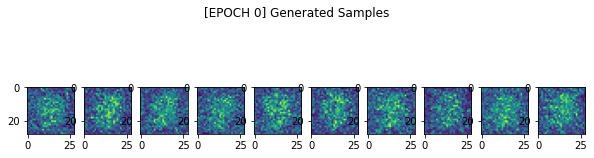

[EPOCH 1] SAMPLED G LOSS : 0.5218636989593506, SAMPLED D LOSS : 0.6220114231109619
[EPOCH 1] SAMPLED G LOSS : 0.5677242875099182, SAMPLED D LOSS : 0.6503990888595581
[EPOCH 2] SAMPLED G LOSS : 0.605781614780426, SAMPLED D LOSS : 0.6316143274307251
[EPOCH 2] SAMPLED G LOSS : 0.654735803604126, SAMPLED D LOSS : 0.6025490760803223
[EPOCH 3] SAMPLED G LOSS : 0.6618580222129822, SAMPLED D LOSS : 0.6032603979110718
[EPOCH 3] SAMPLED G LOSS : 0.6914136409759521, SAMPLED D LOSS : 0.5798744559288025
[EPOCH 4] SAMPLED G LOSS : 0.7049820423126221, SAMPLED D LOSS : 0.5855504870414734
[EPOCH 4] SAMPLED G LOSS : 0.7186881303787231, SAMPLED D LOSS : 0.5425912141799927
[EPOCH 5] SAMPLED G LOSS : 0.816889226436615, SAMPLED D LOSS : 0.5181264281272888
[EPOCH 5] SAMPLED G LOSS : 0.8546802997589111, SAMPLED D LOSS : 0.5180351734161377
[EPOCH 6] SAMPLED G LOSS : 0.8271944522857666, SAMPLED D LOSS : 0.4854362905025482
[EPOCH 6] SAMPLED G LOSS : 0.9492658972740173, SAMPLED D LOSS : 0.43429821729660034
[EPOCH

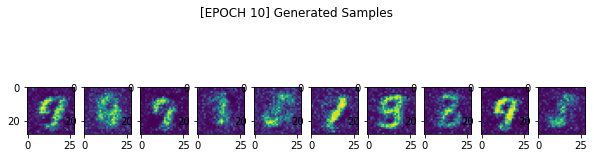

[EPOCH 11] SAMPLED G LOSS : 0.8129974603652954, SAMPLED D LOSS : 0.4910179376602173
[EPOCH 11] SAMPLED G LOSS : 1.0417759418487549, SAMPLED D LOSS : 0.4498996436595917
[EPOCH 12] SAMPLED G LOSS : 1.0731406211853027, SAMPLED D LOSS : 0.4534524381160736
[EPOCH 12] SAMPLED G LOSS : 0.8859025239944458, SAMPLED D LOSS : 0.4669341742992401
[EPOCH 13] SAMPLED G LOSS : 0.9700508117675781, SAMPLED D LOSS : 0.4209080934524536
[EPOCH 13] SAMPLED G LOSS : 1.1249558925628662, SAMPLED D LOSS : 0.3935434818267822
[EPOCH 14] SAMPLED G LOSS : 0.9073368310928345, SAMPLED D LOSS : 0.41402775049209595
[EPOCH 14] SAMPLED G LOSS : 1.1605520248413086, SAMPLED D LOSS : 0.43848347663879395
[EPOCH 15] SAMPLED G LOSS : 0.9266876578330994, SAMPLED D LOSS : 0.44802266359329224
[EPOCH 15] SAMPLED G LOSS : 1.1843241453170776, SAMPLED D LOSS : 0.4095306396484375
[EPOCH 16] SAMPLED G LOSS : 0.9627314805984497, SAMPLED D LOSS : 0.46125322580337524
[EPOCH 16] SAMPLED G LOSS : 0.942387580871582, SAMPLED D LOSS : 0.466573

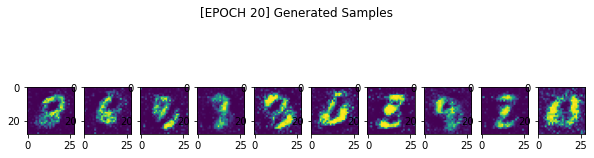

[EPOCH 21] SAMPLED G LOSS : 0.9230445623397827, SAMPLED D LOSS : 0.49269455671310425
[EPOCH 21] SAMPLED G LOSS : 1.2114522457122803, SAMPLED D LOSS : 0.47012320160865784
[EPOCH 22] SAMPLED G LOSS : 0.9819333553314209, SAMPLED D LOSS : 0.446681946516037
[EPOCH 22] SAMPLED G LOSS : 0.9842230677604675, SAMPLED D LOSS : 0.4597184956073761
[EPOCH 23] SAMPLED G LOSS : 0.6794617176055908, SAMPLED D LOSS : 0.5186288952827454
[EPOCH 23] SAMPLED G LOSS : 1.127776861190796, SAMPLED D LOSS : 0.5159646272659302
[EPOCH 24] SAMPLED G LOSS : 0.9785394668579102, SAMPLED D LOSS : 0.4985894560813904
[EPOCH 24] SAMPLED G LOSS : 1.089829683303833, SAMPLED D LOSS : 0.4198264181613922
[EPOCH 25] SAMPLED G LOSS : 1.1064648628234863, SAMPLED D LOSS : 0.44060879945755005
[EPOCH 25] SAMPLED G LOSS : 0.8442996740341187, SAMPLED D LOSS : 0.4877932369709015
[EPOCH 26] SAMPLED G LOSS : 0.7255359888076782, SAMPLED D LOSS : 0.5465056896209717
[EPOCH 26] SAMPLED G LOSS : 1.1599066257476807, SAMPLED D LOSS : 0.496249496

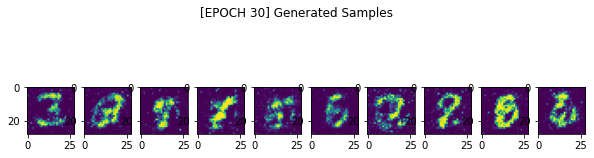

[EPOCH 31] SAMPLED G LOSS : 1.3821717500686646, SAMPLED D LOSS : 0.5122240781784058
[EPOCH 31] SAMPLED G LOSS : 1.0397908687591553, SAMPLED D LOSS : 0.5059625506401062
[EPOCH 32] SAMPLED G LOSS : 1.0173746347427368, SAMPLED D LOSS : 0.43046635389328003
[EPOCH 32] SAMPLED G LOSS : 1.3975169658660889, SAMPLED D LOSS : 0.41643115878105164
[EPOCH 33] SAMPLED G LOSS : 0.8197472095489502, SAMPLED D LOSS : 0.5040704607963562
[EPOCH 33] SAMPLED G LOSS : 1.2227940559387207, SAMPLED D LOSS : 0.5156161785125732
[EPOCH 34] SAMPLED G LOSS : 1.0615556240081787, SAMPLED D LOSS : 0.4790456295013428
[EPOCH 34] SAMPLED G LOSS : 0.9961284399032593, SAMPLED D LOSS : 0.471809983253479
[EPOCH 35] SAMPLED G LOSS : 0.7505369186401367, SAMPLED D LOSS : 0.5147380828857422
[EPOCH 35] SAMPLED G LOSS : 1.012073040008545, SAMPLED D LOSS : 0.490051805973053
[EPOCH 36] SAMPLED G LOSS : 1.2592122554779053, SAMPLED D LOSS : 0.5467818379402161
[EPOCH 36] SAMPLED G LOSS : 1.3249222040176392, SAMPLED D LOSS : 0.4881961941

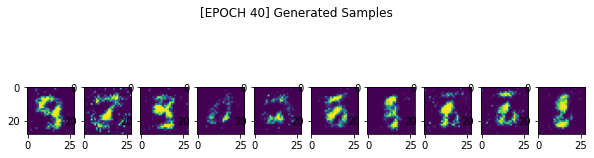

[EPOCH 41] SAMPLED G LOSS : 1.3564271926879883, SAMPLED D LOSS : 0.5416672229766846
[EPOCH 41] SAMPLED G LOSS : 1.165290117263794, SAMPLED D LOSS : 0.5045279860496521
[EPOCH 42] SAMPLED G LOSS : 1.3585939407348633, SAMPLED D LOSS : 0.4819774627685547
[EPOCH 42] SAMPLED G LOSS : 0.7895151972770691, SAMPLED D LOSS : 0.5048366785049438
[EPOCH 43] SAMPLED G LOSS : 1.021812081336975, SAMPLED D LOSS : 0.53378826379776
[EPOCH 43] SAMPLED G LOSS : 1.1020264625549316, SAMPLED D LOSS : 0.531508207321167
[EPOCH 44] SAMPLED G LOSS : 1.1888439655303955, SAMPLED D LOSS : 0.47785401344299316
[EPOCH 44] SAMPLED G LOSS : 1.3942357301712036, SAMPLED D LOSS : 0.5073628425598145
[EPOCH 45] SAMPLED G LOSS : 1.053797960281372, SAMPLED D LOSS : 0.5156998634338379
[EPOCH 45] SAMPLED G LOSS : 1.2908978462219238, SAMPLED D LOSS : 0.5256860256195068
[EPOCH 46] SAMPLED G LOSS : 1.1973717212677002, SAMPLED D LOSS : 0.5686266422271729
[EPOCH 46] SAMPLED G LOSS : 0.9492108821868896, SAMPLED D LOSS : 0.53868645429611

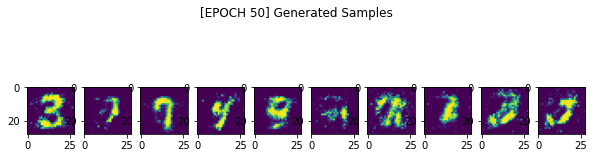

[EPOCH 51] SAMPLED G LOSS : 1.1418663263320923, SAMPLED D LOSS : 0.49598994851112366
[EPOCH 51] SAMPLED G LOSS : 0.9903109073638916, SAMPLED D LOSS : 0.45271480083465576
[EPOCH 52] SAMPLED G LOSS : 1.2600910663604736, SAMPLED D LOSS : 0.4688572287559509
[EPOCH 52] SAMPLED G LOSS : 1.3744080066680908, SAMPLED D LOSS : 0.47778433561325073
[EPOCH 53] SAMPLED G LOSS : 0.9324759244918823, SAMPLED D LOSS : 0.5018481016159058
[EPOCH 53] SAMPLED G LOSS : 1.02353835105896, SAMPLED D LOSS : 0.44619500637054443
[EPOCH 54] SAMPLED G LOSS : 0.9094510078430176, SAMPLED D LOSS : 0.532051146030426
[EPOCH 54] SAMPLED G LOSS : 1.0111308097839355, SAMPLED D LOSS : 0.48917263746261597
[EPOCH 55] SAMPLED G LOSS : 0.7208679914474487, SAMPLED D LOSS : 0.5285903811454773
[EPOCH 55] SAMPLED G LOSS : 0.9099801778793335, SAMPLED D LOSS : 0.47577551007270813
[EPOCH 56] SAMPLED G LOSS : 1.3433191776275635, SAMPLED D LOSS : 0.4957917630672455
[EPOCH 56] SAMPLED G LOSS : 1.2285716533660889, SAMPLED D LOSS : 0.480555

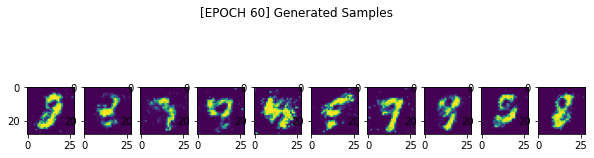

[EPOCH 61] SAMPLED G LOSS : 1.2257503271102905, SAMPLED D LOSS : 0.4575457274913788
[EPOCH 61] SAMPLED G LOSS : 1.3866562843322754, SAMPLED D LOSS : 0.4773136377334595
[EPOCH 62] SAMPLED G LOSS : 1.2001900672912598, SAMPLED D LOSS : 0.44231778383255005
[EPOCH 62] SAMPLED G LOSS : 0.9188278913497925, SAMPLED D LOSS : 0.4626576006412506
[EPOCH 63] SAMPLED G LOSS : 1.2844452857971191, SAMPLED D LOSS : 0.489200234413147
[EPOCH 63] SAMPLED G LOSS : 0.9662395119667053, SAMPLED D LOSS : 0.5411399006843567
[EPOCH 64] SAMPLED G LOSS : 0.8489817380905151, SAMPLED D LOSS : 0.5204038023948669
[EPOCH 64] SAMPLED G LOSS : 1.0420851707458496, SAMPLED D LOSS : 0.5043787956237793
[EPOCH 65] SAMPLED G LOSS : 0.7691666483879089, SAMPLED D LOSS : 0.5213825106620789
[EPOCH 65] SAMPLED G LOSS : 1.165511131286621, SAMPLED D LOSS : 0.5252361297607422
[EPOCH 66] SAMPLED G LOSS : 1.2558507919311523, SAMPLED D LOSS : 0.4828123152256012
[EPOCH 66] SAMPLED G LOSS : 1.2105152606964111, SAMPLED D LOSS : 0.4526718258

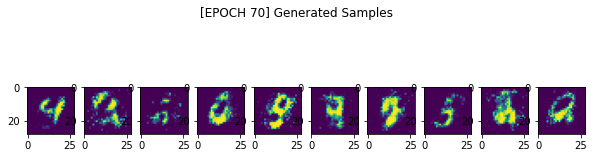

[EPOCH 71] SAMPLED G LOSS : 0.8394613265991211, SAMPLED D LOSS : 0.5202343463897705
[EPOCH 71] SAMPLED G LOSS : 1.0183037519454956, SAMPLED D LOSS : 0.4987047612667084
[EPOCH 72] SAMPLED G LOSS : 1.3463492393493652, SAMPLED D LOSS : 0.4893588423728943
[EPOCH 72] SAMPLED G LOSS : 1.2041224241256714, SAMPLED D LOSS : 0.4967745244503021
[EPOCH 73] SAMPLED G LOSS : 0.8639294505119324, SAMPLED D LOSS : 0.48646456003189087
[EPOCH 73] SAMPLED G LOSS : 1.1098480224609375, SAMPLED D LOSS : 0.4980621933937073
[EPOCH 74] SAMPLED G LOSS : 1.097446084022522, SAMPLED D LOSS : 0.5285126566886902
[EPOCH 74] SAMPLED G LOSS : 0.9816208481788635, SAMPLED D LOSS : 0.5019257068634033
[EPOCH 75] SAMPLED G LOSS : 0.8378825783729553, SAMPLED D LOSS : 0.5280791521072388
[EPOCH 75] SAMPLED G LOSS : 1.448779821395874, SAMPLED D LOSS : 0.5324304699897766
[EPOCH 76] SAMPLED G LOSS : 1.2527976036071777, SAMPLED D LOSS : 0.4971640110015869
[EPOCH 76] SAMPLED G LOSS : 0.6066436767578125, SAMPLED D LOSS : 0.5939180254

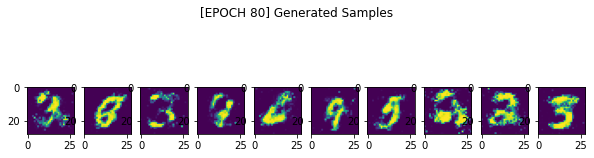

[EPOCH 81] SAMPLED G LOSS : 0.9266335964202881, SAMPLED D LOSS : 0.5017110705375671
[EPOCH 81] SAMPLED G LOSS : 1.0312490463256836, SAMPLED D LOSS : 0.49141985177993774
[EPOCH 82] SAMPLED G LOSS : 1.2822132110595703, SAMPLED D LOSS : 0.515170693397522
[EPOCH 82] SAMPLED G LOSS : 1.126951813697815, SAMPLED D LOSS : 0.502173662185669
[EPOCH 83] SAMPLED G LOSS : 1.1314435005187988, SAMPLED D LOSS : 0.5272172689437866
[EPOCH 83] SAMPLED G LOSS : 1.4238862991333008, SAMPLED D LOSS : 0.5084203481674194
[EPOCH 84] SAMPLED G LOSS : 0.9391276240348816, SAMPLED D LOSS : 0.47655579447746277
[EPOCH 84] SAMPLED G LOSS : 1.1424884796142578, SAMPLED D LOSS : 0.49726900458335876
[EPOCH 85] SAMPLED G LOSS : 0.8989896178245544, SAMPLED D LOSS : 0.5492685437202454
[EPOCH 85] SAMPLED G LOSS : 1.1130115985870361, SAMPLED D LOSS : 0.46765339374542236
[EPOCH 86] SAMPLED G LOSS : 1.5131194591522217, SAMPLED D LOSS : 0.49003714323043823
[EPOCH 86] SAMPLED G LOSS : 1.7490675449371338, SAMPLED D LOSS : 0.5161285

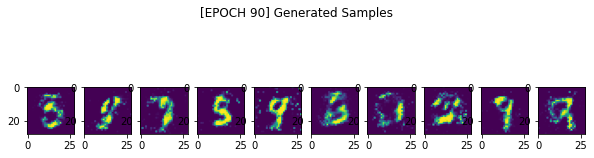

[EPOCH 91] SAMPLED G LOSS : 1.035892367362976, SAMPLED D LOSS : 0.479804128408432
[EPOCH 91] SAMPLED G LOSS : 1.3149991035461426, SAMPLED D LOSS : 0.5053269267082214
[EPOCH 92] SAMPLED G LOSS : 1.1864993572235107, SAMPLED D LOSS : 0.538080096244812
[EPOCH 92] SAMPLED G LOSS : 0.8749345541000366, SAMPLED D LOSS : 0.5390624403953552
[EPOCH 93] SAMPLED G LOSS : 0.9626006484031677, SAMPLED D LOSS : 0.49478060007095337
[EPOCH 93] SAMPLED G LOSS : 1.0930218696594238, SAMPLED D LOSS : 0.4750129282474518
[EPOCH 94] SAMPLED G LOSS : 0.5467396378517151, SAMPLED D LOSS : 0.605093240737915
[EPOCH 94] SAMPLED G LOSS : 0.8691264390945435, SAMPLED D LOSS : 0.47664588689804077
[EPOCH 95] SAMPLED G LOSS : 1.1286463737487793, SAMPLED D LOSS : 0.4646485447883606
[EPOCH 95] SAMPLED G LOSS : 0.9577941298484802, SAMPLED D LOSS : 0.553003191947937
[EPOCH 96] SAMPLED G LOSS : 1.582748532295227, SAMPLED D LOSS : 0.517285943031311
[EPOCH 96] SAMPLED G LOSS : 1.4194045066833496, SAMPLED D LOSS : 0.47957170009613

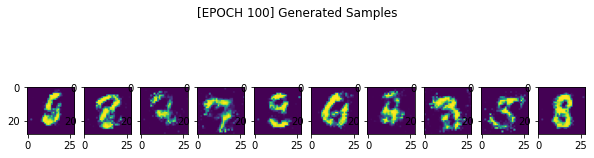

[EPOCH 101] SAMPLED G LOSS : 1.423903465270996, SAMPLED D LOSS : 0.4863685071468353
[EPOCH 101] SAMPLED G LOSS : 1.4452345371246338, SAMPLED D LOSS : 0.4277576804161072
[EPOCH 102] SAMPLED G LOSS : 1.033312439918518, SAMPLED D LOSS : 0.5225350856781006
[EPOCH 102] SAMPLED G LOSS : 0.7781412601470947, SAMPLED D LOSS : 0.5511609315872192
[EPOCH 103] SAMPLED G LOSS : 0.6042493581771851, SAMPLED D LOSS : 0.6003820896148682
[EPOCH 103] SAMPLED G LOSS : 0.8734599351882935, SAMPLED D LOSS : 0.48441386222839355
[EPOCH 104] SAMPLED G LOSS : 1.47891366481781, SAMPLED D LOSS : 0.47262513637542725
[EPOCH 104] SAMPLED G LOSS : 1.6266491413116455, SAMPLED D LOSS : 0.5442452430725098
[EPOCH 105] SAMPLED G LOSS : 1.1548305749893188, SAMPLED D LOSS : 0.49116671085357666
[EPOCH 105] SAMPLED G LOSS : 1.6171612739562988, SAMPLED D LOSS : 0.5034636855125427
[EPOCH 106] SAMPLED G LOSS : 0.9782101511955261, SAMPLED D LOSS : 0.48280179500579834
[EPOCH 106] SAMPLED G LOSS : 1.3762829303741455, SAMPLED D LOSS :

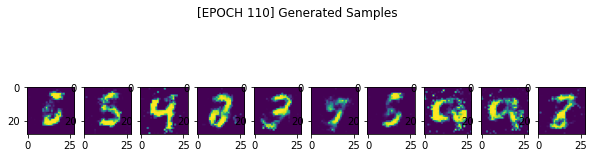

[EPOCH 111] SAMPLED G LOSS : 1.5576915740966797, SAMPLED D LOSS : 0.5852522850036621
[EPOCH 111] SAMPLED G LOSS : 1.3868299722671509, SAMPLED D LOSS : 0.46265849471092224
[EPOCH 112] SAMPLED G LOSS : 0.7085056304931641, SAMPLED D LOSS : 0.5451730489730835
[EPOCH 112] SAMPLED G LOSS : 1.273180603981018, SAMPLED D LOSS : 0.49796944856643677
[EPOCH 113] SAMPLED G LOSS : 0.9116618037223816, SAMPLED D LOSS : 0.48898085951805115
[EPOCH 113] SAMPLED G LOSS : 1.3762587308883667, SAMPLED D LOSS : 0.5223417282104492
[EPOCH 114] SAMPLED G LOSS : 0.9548420906066895, SAMPLED D LOSS : 0.47216546535491943
[EPOCH 114] SAMPLED G LOSS : 1.190017819404602, SAMPLED D LOSS : 0.5094558596611023
[EPOCH 115] SAMPLED G LOSS : 1.123997688293457, SAMPLED D LOSS : 0.4773164987564087
[EPOCH 115] SAMPLED G LOSS : 1.3337807655334473, SAMPLED D LOSS : 0.4270400106906891
[EPOCH 116] SAMPLED G LOSS : 0.8916839361190796, SAMPLED D LOSS : 0.5362860560417175
[EPOCH 116] SAMPLED G LOSS : 1.0512040853500366, SAMPLED D LOSS 

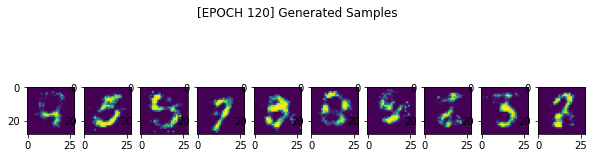

[EPOCH 121] SAMPLED G LOSS : 1.2134052515029907, SAMPLED D LOSS : 0.5209469795227051
[EPOCH 121] SAMPLED G LOSS : 1.3080999851226807, SAMPLED D LOSS : 0.46395131945610046
[EPOCH 122] SAMPLED G LOSS : 1.5217267274856567, SAMPLED D LOSS : 0.5511250495910645
[EPOCH 122] SAMPLED G LOSS : 1.1186707019805908, SAMPLED D LOSS : 0.5382115840911865
[EPOCH 123] SAMPLED G LOSS : 1.4403190612792969, SAMPLED D LOSS : 0.5572181940078735
[EPOCH 123] SAMPLED G LOSS : 1.4540646076202393, SAMPLED D LOSS : 0.49888354539871216
[EPOCH 124] SAMPLED G LOSS : 1.3938612937927246, SAMPLED D LOSS : 0.5752183794975281
[EPOCH 124] SAMPLED G LOSS : 1.0687580108642578, SAMPLED D LOSS : 0.44553524255752563
[EPOCH 125] SAMPLED G LOSS : 1.3367936611175537, SAMPLED D LOSS : 0.5266247987747192
[EPOCH 125] SAMPLED G LOSS : 1.010667085647583, SAMPLED D LOSS : 0.5471169948577881
[EPOCH 126] SAMPLED G LOSS : 1.15012526512146, SAMPLED D LOSS : 0.49187755584716797
[EPOCH 126] SAMPLED G LOSS : 1.3802976608276367, SAMPLED D LOSS 

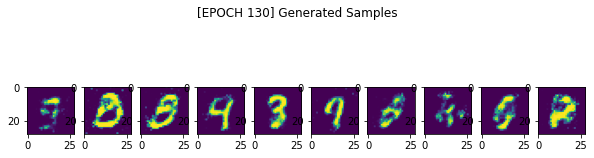

[EPOCH 131] SAMPLED G LOSS : 1.1560585498809814, SAMPLED D LOSS : 0.4985555410385132
[EPOCH 131] SAMPLED G LOSS : 1.3499513864517212, SAMPLED D LOSS : 0.44930264353752136
[EPOCH 132] SAMPLED G LOSS : 1.4081981182098389, SAMPLED D LOSS : 0.5090879797935486
[EPOCH 132] SAMPLED G LOSS : 0.8351989984512329, SAMPLED D LOSS : 0.5571370124816895
[EPOCH 133] SAMPLED G LOSS : 1.4866328239440918, SAMPLED D LOSS : 0.4659012258052826
[EPOCH 133] SAMPLED G LOSS : 0.7274025678634644, SAMPLED D LOSS : 0.5658713579177856
[EPOCH 134] SAMPLED G LOSS : 1.1875672340393066, SAMPLED D LOSS : 0.5031312704086304
[EPOCH 134] SAMPLED G LOSS : 0.9124333262443542, SAMPLED D LOSS : 0.5109703540802002
[EPOCH 135] SAMPLED G LOSS : 0.9845603704452515, SAMPLED D LOSS : 0.5195180773735046
[EPOCH 135] SAMPLED G LOSS : 1.196385145187378, SAMPLED D LOSS : 0.4879678189754486
[EPOCH 136] SAMPLED G LOSS : 1.0975772142410278, SAMPLED D LOSS : 0.49118465185165405
[EPOCH 136] SAMPLED G LOSS : 1.1975743770599365, SAMPLED D LOSS 

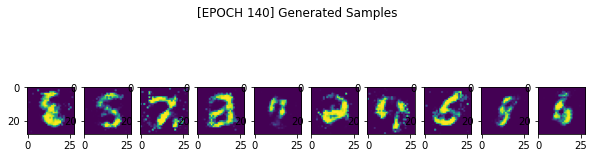

[EPOCH 141] SAMPLED G LOSS : 0.9314243793487549, SAMPLED D LOSS : 0.5234792232513428
[EPOCH 141] SAMPLED G LOSS : 1.5712356567382812, SAMPLED D LOSS : 0.5143542885780334
[EPOCH 142] SAMPLED G LOSS : 0.9957530498504639, SAMPLED D LOSS : 0.4745398759841919
[EPOCH 142] SAMPLED G LOSS : 1.0463188886642456, SAMPLED D LOSS : 0.5240181684494019
[EPOCH 143] SAMPLED G LOSS : 1.0797501802444458, SAMPLED D LOSS : 0.4923861026763916
[EPOCH 143] SAMPLED G LOSS : 1.037522315979004, SAMPLED D LOSS : 0.609675943851471
[EPOCH 144] SAMPLED G LOSS : 0.833251953125, SAMPLED D LOSS : 0.5746428966522217
[EPOCH 144] SAMPLED G LOSS : 0.9756223559379578, SAMPLED D LOSS : 0.5610991716384888
[EPOCH 145] SAMPLED G LOSS : 1.2494933605194092, SAMPLED D LOSS : 0.5331473350524902
[EPOCH 145] SAMPLED G LOSS : 1.478987455368042, SAMPLED D LOSS : 0.5000436305999756
[EPOCH 146] SAMPLED G LOSS : 1.1619592905044556, SAMPLED D LOSS : 0.49402761459350586
[EPOCH 146] SAMPLED G LOSS : 1.1651709079742432, SAMPLED D LOSS : 0.490

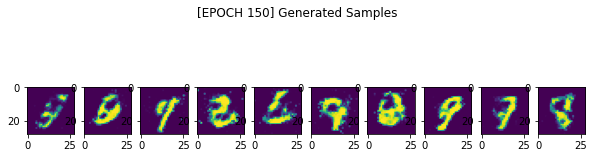

[EPOCH 151] SAMPLED G LOSS : 1.5852094888687134, SAMPLED D LOSS : 0.5358996987342834
[EPOCH 151] SAMPLED G LOSS : 1.307956337928772, SAMPLED D LOSS : 0.5979253053665161
[EPOCH 152] SAMPLED G LOSS : 1.3027894496917725, SAMPLED D LOSS : 0.5012117028236389
[EPOCH 152] SAMPLED G LOSS : 0.7761507034301758, SAMPLED D LOSS : 0.5453611016273499
[EPOCH 153] SAMPLED G LOSS : 1.0224616527557373, SAMPLED D LOSS : 0.5258656740188599
[EPOCH 153] SAMPLED G LOSS : 1.0199946165084839, SAMPLED D LOSS : 0.5374295711517334
[EPOCH 154] SAMPLED G LOSS : 1.4573090076446533, SAMPLED D LOSS : 0.4784794747829437
[EPOCH 154] SAMPLED G LOSS : 1.4191303253173828, SAMPLED D LOSS : 0.4710219204425812
[EPOCH 155] SAMPLED G LOSS : 1.1684634685516357, SAMPLED D LOSS : 0.5233715772628784
[EPOCH 155] SAMPLED G LOSS : 0.9773069024085999, SAMPLED D LOSS : 0.5447412729263306
[EPOCH 156] SAMPLED G LOSS : 1.2279205322265625, SAMPLED D LOSS : 0.45057475566864014
[EPOCH 156] SAMPLED G LOSS : 0.8188463449478149, SAMPLED D LOSS :

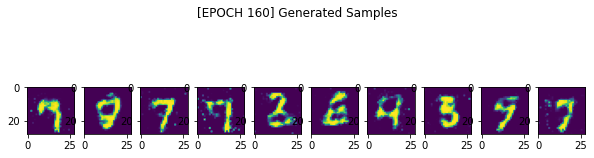

[EPOCH 161] SAMPLED G LOSS : 1.2725838422775269, SAMPLED D LOSS : 0.5545648336410522
[EPOCH 161] SAMPLED G LOSS : 1.3502544164657593, SAMPLED D LOSS : 0.48071569204330444
[EPOCH 162] SAMPLED G LOSS : 1.2326416969299316, SAMPLED D LOSS : 0.5539736747741699
[EPOCH 162] SAMPLED G LOSS : 1.789121389389038, SAMPLED D LOSS : 0.5868377685546875
[EPOCH 163] SAMPLED G LOSS : 1.1380946636199951, SAMPLED D LOSS : 0.525312066078186
[EPOCH 163] SAMPLED G LOSS : 0.9271247386932373, SAMPLED D LOSS : 0.5076331496238708
[EPOCH 164] SAMPLED G LOSS : 1.0610361099243164, SAMPLED D LOSS : 0.5443769097328186
[EPOCH 164] SAMPLED G LOSS : 1.1573853492736816, SAMPLED D LOSS : 0.5151443481445312
[EPOCH 165] SAMPLED G LOSS : 1.0995604991912842, SAMPLED D LOSS : 0.5958861112594604
[EPOCH 165] SAMPLED G LOSS : 1.0456491708755493, SAMPLED D LOSS : 0.5163891911506653
[EPOCH 166] SAMPLED G LOSS : 1.0176060199737549, SAMPLED D LOSS : 0.5076760053634644
[EPOCH 166] SAMPLED G LOSS : 1.1599525213241577, SAMPLED D LOSS : 

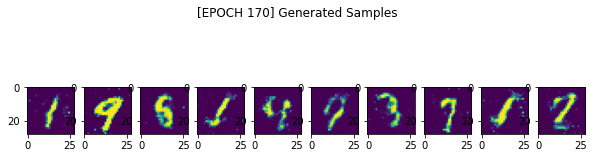

[EPOCH 171] SAMPLED G LOSS : 1.74684476852417, SAMPLED D LOSS : 0.4948478937149048
[EPOCH 171] SAMPLED G LOSS : 1.0963671207427979, SAMPLED D LOSS : 0.4751071333885193
[EPOCH 172] SAMPLED G LOSS : 1.4450695514678955, SAMPLED D LOSS : 0.4981107711791992
[EPOCH 172] SAMPLED G LOSS : 1.1915937662124634, SAMPLED D LOSS : 0.5258013010025024
[EPOCH 173] SAMPLED G LOSS : 1.1208007335662842, SAMPLED D LOSS : 0.5064669251441956
[EPOCH 173] SAMPLED G LOSS : 1.4091598987579346, SAMPLED D LOSS : 0.5842621326446533
[EPOCH 174] SAMPLED G LOSS : 1.9239882230758667, SAMPLED D LOSS : 0.6161189675331116
[EPOCH 174] SAMPLED G LOSS : 1.230494499206543, SAMPLED D LOSS : 0.5128690600395203
[EPOCH 175] SAMPLED G LOSS : 0.843940258026123, SAMPLED D LOSS : 0.5425442457199097
[EPOCH 175] SAMPLED G LOSS : 0.962646484375, SAMPLED D LOSS : 0.5583233833312988
[EPOCH 176] SAMPLED G LOSS : 1.7998411655426025, SAMPLED D LOSS : 0.61607426404953
[EPOCH 176] SAMPLED G LOSS : 1.16798734664917, SAMPLED D LOSS : 0.524320960

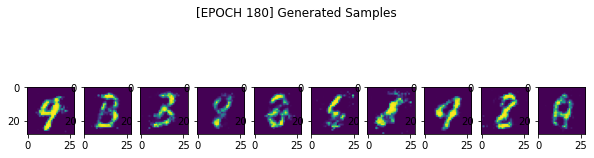

[EPOCH 181] SAMPLED G LOSS : 0.9518734216690063, SAMPLED D LOSS : 0.5332077741622925
[EPOCH 181] SAMPLED G LOSS : 1.0947654247283936, SAMPLED D LOSS : 0.46924519538879395
[EPOCH 182] SAMPLED G LOSS : 1.1631685495376587, SAMPLED D LOSS : 0.48193463683128357
[EPOCH 182] SAMPLED G LOSS : 0.7890361547470093, SAMPLED D LOSS : 0.5194271802902222
[EPOCH 183] SAMPLED G LOSS : 1.052844762802124, SAMPLED D LOSS : 0.5142764449119568
[EPOCH 183] SAMPLED G LOSS : 0.8989540338516235, SAMPLED D LOSS : 0.5340138673782349
[EPOCH 184] SAMPLED G LOSS : 1.304949164390564, SAMPLED D LOSS : 0.5046401023864746
[EPOCH 184] SAMPLED G LOSS : 1.3989354372024536, SAMPLED D LOSS : 0.48099249601364136
[EPOCH 185] SAMPLED G LOSS : 0.8717566728591919, SAMPLED D LOSS : 0.5449248552322388
[EPOCH 185] SAMPLED G LOSS : 1.0676192045211792, SAMPLED D LOSS : 0.4753316342830658
[EPOCH 186] SAMPLED G LOSS : 0.8955656886100769, SAMPLED D LOSS : 0.49968981742858887
[EPOCH 186] SAMPLED G LOSS : 1.1544469594955444, SAMPLED D LOSS

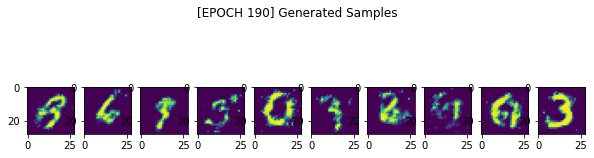

[EPOCH 191] SAMPLED G LOSS : 1.6667530536651611, SAMPLED D LOSS : 0.522905707359314
[EPOCH 191] SAMPLED G LOSS : 1.0878562927246094, SAMPLED D LOSS : 0.5998777151107788
[EPOCH 192] SAMPLED G LOSS : 0.4278213381767273, SAMPLED D LOSS : 0.6850113272666931
[EPOCH 192] SAMPLED G LOSS : 1.0576989650726318, SAMPLED D LOSS : 0.5131518840789795
[EPOCH 193] SAMPLED G LOSS : 1.3608601093292236, SAMPLED D LOSS : 0.5236301422119141
[EPOCH 193] SAMPLED G LOSS : 1.0718356370925903, SAMPLED D LOSS : 0.512744128704071
[EPOCH 194] SAMPLED G LOSS : 1.0816340446472168, SAMPLED D LOSS : 0.5508911609649658
[EPOCH 194] SAMPLED G LOSS : 1.2340854406356812, SAMPLED D LOSS : 0.49071037769317627
[EPOCH 195] SAMPLED G LOSS : 1.050434947013855, SAMPLED D LOSS : 0.5224079489707947
[EPOCH 195] SAMPLED G LOSS : 1.266087293624878, SAMPLED D LOSS : 0.49511197209358215
[EPOCH 196] SAMPLED G LOSS : 1.2899506092071533, SAMPLED D LOSS : 0.5339175462722778
[EPOCH 196] SAMPLED G LOSS : 1.1740190982818604, SAMPLED D LOSS : 0

In [ ]:
max_epoch = 200

for epoch in tqdm(range(max_epoch)):        
    for idx, sample in enumerate(train_dataloader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample)
        if idx % 200 == 0:
            print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))

    if epoch % 10 == 0:
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(generator, img_size, dim_z))
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch))
        plt.pause(0.1)
        

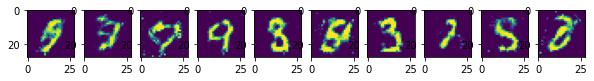

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(generator, img_size, dim_z))
